In [1]:
import os
import json
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import open3d as o3d
import torch
from torch import nn

from plyfile import PlyData, PlyElement
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import joblib
import seaborn as sns

import lightgbm as lgb

import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('/home/tsy/Documents/TeamM_Defog/kpro-dehaze/projects/fog_removal/scripts')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# 1. Set the path to test PLY file
PLY_PATH = "/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/test/kpro/kpro_density_025.ply"
# PLY_PATH = "/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/train/processed/phase1/playroom/playroom_beta4_alpha225.ply"
# PLY_PATH = "/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/train/processed/phase1/drjohnson/drjohnson_beta2_alpha050.ply"
# PLY_PATH = "/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/test/tandt/pcl_train_level5.ply"
# PLY_PATH = "/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/train/processed/phase1/truck/truck_beta5_alpha050.ply"

# 2. Set the experiment directory
## Basic features
experiment_dir = '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_all'
## Spatial features
# experiment_dir = '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/fog_classification_neighborhood_features_20250920_154903'

In [3]:
class PointCloudModel(nn.Module):
    def __init__(self, max_sh_degree=3, device="cpu"):
        super(PointCloudModel, self).__init__()
        self.max_sh_degree = max_sh_degree
        self._xyz = None
        self._features_dc = None
        self._features_rest = None
        self._opacity = None
        self._scaling = None
        self._rotation = None
        self.pretrained_exposures = None
        self.device = device

    def load_ply(self, path, use_train_test_exp=False):
        """
        Additional Explanation of the point cloud model's features:
        |---------------------------------------------------------------------------------------------------------------------------------------------------|
        | Variable              | Meaning                                                 | Typical Shape (if RGB)                                          |
        | --------------------- | ------------------------------------------------------- | --------------------------------------------------------------- |
        | `self._features_dc`   | Zeroth-order SH coefficients (constant per point color) | `[N_points, 3]`                                                 |
        | `self._features_rest` | Higher-order SH coefficients (view-dependent features)  | `[N_points, 3 x (n_SH - 1)]` where `n_SH = (max_sh_degree+1)^2` |
        |---------------------------------------------------------------------------------------------------------------------------------------------------|
        """
        plydata = PlyData.read(path)
        if use_train_test_exp:
            exposure_file = os.path.join(os.path.dirname(path), os.pardir, os.pardir, "exposure.json")
            if os.path.exists(exposure_file):
                with open(exposure_file, "r") as f:
                    exposures = json.load(f)
                self.pretrained_exposures = {image_name: torch.FloatTensor(exposures[image_name]).requires_grad_(False).cuda() for image_name in exposures}
                print(f"Pretrained exposures loaded.")
            else:
                print(f"No exposure to be loaded at {exposure_file}")
                self.pretrained_exposures = None

        xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                        np.asarray(plydata.elements[0]["y"]),
                        np.asarray(plydata.elements[0]["z"])),  axis=1)
        opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

        features_dc = np.zeros((xyz.shape[0], 3, 1))
        features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
        features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
        features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

        extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
        extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
        assert len(extra_f_names)==3*(self.max_sh_degree + 1) ** 2 - 3
        features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
        for idx, attr_name in enumerate(extra_f_names):
            features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
        # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
        # features_extra = features_extra.reshape((features_extra.shape[0], 3, (self.max_sh_degree + 1) ** 2 - 1))

        scale_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("scale_")]
        scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
        scales = np.zeros((xyz.shape[0], len(scale_names)))
        for idx, attr_name in enumerate(scale_names):
            scales[:, idx] = np.asarray(plydata.elements[0][attr_name])

        rot_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("rot")]
        rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
        rots = np.zeros((xyz.shape[0], len(rot_names)))
        for idx, attr_name in enumerate(rot_names):
            rots[:, idx] = np.asarray(plydata.elements[0][attr_name])

        self._xyz = nn.Parameter(torch.tensor(xyz, dtype=torch.float, device=self.device).requires_grad_(True))
        self._features_dc = nn.Parameter(torch.tensor(features_dc, dtype=torch.float, device=self.device).transpose(1, 2).contiguous().requires_grad_(True))
        # self._features_rest = nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device=self.device).transpose(1, 2).contiguous().requires_grad_(True))
        self._features_rest = nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device=self.device).requires_grad_(True))
        self._opacity = nn.Parameter(torch.tensor(opacities, dtype=torch.float, device=self.device).requires_grad_(True))
        self._scaling = nn.Parameter(torch.tensor(scales, dtype=torch.float, device=self.device).requires_grad_(True))
        self._rotation = nn.Parameter(torch.tensor(rots, dtype=torch.float, device=self.device).requires_grad_(True))

        self.active_sh_degree = self.max_sh_degree


    def convert_ply_to_df(self, beta, alpha, id, df_range=[], add_spatial_features=False, do_log=False):
        
        data_dict = {
            'position': self._xyz.detach().numpy(),
            'f_dc': self._features_dc.detach().numpy(),
            'f_rest': self._features_rest.detach().numpy(),
            'opacity': self._opacity.detach().numpy(),
            'scale': self._scaling.detach().numpy(),
            'rotation': self._rotation.detach().numpy(),
            'beta': beta * np.ones(self._opacity.detach().numpy().shape),
            'alpha': alpha * np.ones(self._opacity.detach().numpy().shape),
            'is_fog': (beta!=0) * np.ones(self._opacity.detach().numpy().shape),
            'id': id * np.ones(self._opacity.detach().numpy().shape)
        }

        
        # Flatten each into separate columns
        df_dict = {}

        # Flatten position
        for i, axis in enumerate(['x', 'y', 'z']):
            df_dict[f'pos_{axis}'] = data_dict['position'][:, i]

        # Flatten feature_dc
        for i, color in enumerate(['0', '1', '2']):
            df_dict[f'f_dc_{color}'] = data_dict['f_dc'][:, 0, i]
        
        # Flatten feature_rest
        for i in range(data_dict['f_rest'].shape[1]):
            df_dict[f'f_rest_{i}'] = data_dict['f_rest'][:, i]

        # Flatten scale
        for i, axis in enumerate(['x', 'y', 'z']):
            df_dict[f'scale_{axis}'] = data_dict['scale'][:, i]

        # Flatten rotation
        for i, axis in enumerate(['0', '1', '2', '3']):
            df_dict[f'rot_{axis}'] = data_dict['rotation'][:, i]

        # Opacity
        df_dict['opacity'] = data_dict['opacity'].squeeze()

        # Flatten feature_rest
        df_dict['beta'] = data_dict['beta'].squeeze()
        df_dict['alpha'] = data_dict['alpha'].squeeze()
        df_dict['is_fog'] = data_dict['is_fog'].squeeze()
        df_dict['id'] = data_dict['id'].squeeze()

        
        df = pd.DataFrame(df_dict) if df_range == [] else pd.DataFrame(data_dict).iloc[df_range[0]:df_range[1]]

        if add_spatial_features:
            return self.add_spatial_features(df, do_log=do_log)
        else:
            return df


    def add_spatial_features(self, df, output_file_path=None, radius_list=[0.2, 0.6], k_neighbors=[6, 12], do_log=False):
        """
        Add surrounding gaussian information to each point in the dataset.
        
        Parameters:
        df: pandas.DataFrame - Input dataframe with gaussian data
        output_file_path: str - Path to save the enhanced dataset (optional)
        radius_list: list - List of radii to search for neighbors
        k_neighbors: list - List of k values for k-nearest neighbors
        """
        
        # Load the dataset or use provided dataframe
        if isinstance(df, str):
            if do_log: print("Loading dataset...")
            df = pd.read_csv(df)
        else:
            if do_log: print("Using provided dataframe...")
        if do_log: print(f"Dataset shape: {df.shape}")
        
        # Extract 3D positions
        positions = df[['pos_x', 'pos_y', 'pos_z']].values
        
        # Initialize new feature columns
        new_features = {}
        
        if do_log: print("Computing spatial features...")
        
        # 1. K-Nearest Neighbors features
        if do_log: print("Computing k-nearest neighbors features...")
        for k in k_neighbors:
            if do_log: print(f"  Processing k={k}...")
            
            # Fit k-NN model
            nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(positions)
            distances, indices = nbrs.kneighbors(positions)
            
            # Remove self (first neighbor is always the point itself)
            distances = distances[:, 1:]
            indices = indices[:, 1:]
            
            # Add features based on k-nearest neighbors
            new_features[f'knn_{k}_mean_distance'] = np.mean(distances, axis=1)
            new_features[f'knn_{k}_std_distance'] = np.std(distances, axis=1)
            new_features[f'knn_{k}_max_distance'] = np.max(distances, axis=1)
            new_features[f'knn_{k}_min_distance'] = np.min(distances, axis=1)
            
            # Density-like features
            new_features[f'knn_{k}_density'] = k / (np.mean(distances, axis=1) ** 3)  # Points per unit volume
            
            # Neighbor properties aggregation
            neighbor_opacity = df.iloc[indices.flatten()]['opacity'].values.reshape(indices.shape)
            
            new_features[f'knn_{k}_mean_opacity'] = np.mean(neighbor_opacity, axis=1)
            new_features[f'knn_{k}_std_opacity'] = np.std(neighbor_opacity, axis=1)
            
            # Scale and rotation variation in neighborhood
            for scale_col in ['scale_x', 'scale_y', 'scale_z']:
                neighbor_scale = df.iloc[indices.flatten()][scale_col].values.reshape(indices.shape)
                new_features[f'knn_{k}_{scale_col}_std'] = np.std(neighbor_scale, axis=1)
        
        # 2. Radius-based features
        if do_log: print("Computing radius-based features...")
        for radius in radius_list:
            if do_log: print(f"  Processing radius={radius}...")
            
            # Find neighbors within radius
            nbrs_radius = NearestNeighbors(radius=radius, algorithm='ball_tree').fit(positions)
            distances, indices = nbrs_radius.radius_neighbors(positions)
            
            # Count neighbors within radius (excluding self)
            neighbor_counts = np.array([len(dist) - 1 for dist in distances])  # -1 to exclude self
            new_features[f'radius_{radius}_count'] = neighbor_counts
            
            # Local density
            new_features[f'radius_{radius}_density'] = neighbor_counts / (4/3 * np.pi * radius**3)
            
            # Average properties of neighbors within radius
            radius_mean_opacity = []
            radius_mean_distance = []
            
            for i, (dists, idxs) in enumerate(zip(distances, indices)):
                if len(idxs) > 1:  # More than just self
                    # Remove self (distance 0)
                    mask = dists > 0
                    neighbor_idxs = idxs[mask]
                    neighbor_dists = dists[mask]
                    
                    if len(neighbor_idxs) > 0:
                        radius_mean_opacity.append(df.iloc[neighbor_idxs]['opacity'].mean())
                        radius_mean_distance.append(np.mean(neighbor_dists))
                    else:
                        radius_mean_opacity.append(0)
                        radius_mean_distance.append(radius)
                else:
                    radius_mean_opacity.append(0)
                    radius_mean_distance.append(radius)
            
            new_features[f'radius_{radius}_mean_opacity'] = radius_mean_opacity
            new_features[f'radius_{radius}_mean_distance'] = radius_mean_distance
        
        # # 3. Global position features
        # if do_log: print("Computing global position features...")
        
        # # Distance from center of mass
        # center_of_mass = np.mean(positions, axis=0)
        # distances_from_center = np.linalg.norm(positions - center_of_mass, axis=1)
        # new_features['distance_from_center'] = distances_from_center
        
        # # Height-based features (assuming z is up)
        # new_features['height_percentile'] = df['pos_z'].rank(pct=True) * 100
        
        # 4. Local geometric features
        if do_log: print("Computing local geometric features...")
        
        # For each point, compute the covariance of its nearest neighbors to understand local structure
        k_for_geometry = 10
        nbrs_geom = NearestNeighbors(n_neighbors=k_for_geometry+1, algorithm='ball_tree').fit(positions)
        _, indices_geom = nbrs_geom.kneighbors(positions)
        indices_geom = indices_geom[:, 1:]  # Remove self
        
        local_planarity = []
        local_sphericity = []
        local_linearity = []
        
        for i, neighbor_idx in enumerate(indices_geom):
            neighbor_points = positions[neighbor_idx]
            # Center the points
            centered_points = neighbor_points - np.mean(neighbor_points, axis=0)
            
            # Compute covariance matrix
            if len(centered_points) > 3:  # Need at least 4 points for 3D covariance
                try:
                    cov_matrix = np.cov(centered_points.T)
                    eigenvalues = np.linalg.eigvals(cov_matrix)
                    eigenvalues = np.sort(eigenvalues)[::-1]  # Sort in descending order
                    eigenvalues = np.maximum(eigenvalues, 1e-10)  # Avoid division by zero
                    
                    # Geometric features based on eigenvalues
                    linearity = (eigenvalues[0] - eigenvalues[1]) / eigenvalues[0]
                    planarity = (eigenvalues[1] - eigenvalues[2]) / eigenvalues[0]
                    sphericity = eigenvalues[2] / eigenvalues[0]
                except:
                    linearity = planarity = sphericity = 0
            else:
                linearity = planarity = sphericity = 0
                
            local_linearity.append(linearity)
            local_planarity.append(planarity)
            local_sphericity.append(sphericity)
        
        new_features['local_linearity'] = local_linearity
        new_features['local_planarity'] = local_planarity
        new_features['local_sphericity'] = local_sphericity
        
        # 5. Scale and rotation context features
        if do_log: print("Computing scale and rotation context features...")
        
        # Compare current point's scale with neighborhood average
        k_context = 10
        nbrs_context = NearestNeighbors(n_neighbors=k_context+1, algorithm='ball_tree').fit(positions)
        _, indices_context = nbrs_context.kneighbors(positions)
        indices_context = indices_context[:, 1:]  # Remove self
        
        for scale_col in ['scale_x', 'scale_y', 'scale_z']:
            scale_ratios = []
            for i, neighbor_idx in enumerate(indices_context):
                current_scale = df.iloc[i][scale_col]
                neighbor_scales = df.iloc[neighbor_idx][scale_col].values
                mean_neighbor_scale = np.mean(neighbor_scales)
                if mean_neighbor_scale > 1e-10:  # Avoid division by very small numbers
                    ratio = current_scale / mean_neighbor_scale
                else:
                    ratio = 1.0
                scale_ratios.append(ratio)
            new_features[f'{scale_col}_neighborhood_ratio'] = scale_ratios
        
        # Add all new features to the dataframe
        if do_log: print("Adding features to dataframe...")
        for feature_name, feature_values in new_features.items():
            df[feature_name] = feature_values
        
        if do_log: print(f"Added {len(new_features)} new features")
        if do_log: print(f"Enhanced dataset shape: {df.shape}")
        
        # Save the enhanced dataset
        if output_file_path:
            df.to_csv(output_file_path, index=False)
            if do_log: print(f"Enhanced dataset saved to: {output_file_path}")
        
        # Print feature summary
        if do_log: print("\nNew features added:")
        for feature in sorted(new_features.keys()):
            if do_log: print(f"  - {feature}")
        
        return df

    def convert_df_to_ply(self, df, output_path, normals=None):
        # means, scales, rotations, rgbs, opacities, normals=None):
        means = df[['pos_x', 'pos_y', 'pos_z']].values
        scales = df[['scale_x', 'scale_y', 'scale_z']].values
        rotations = df[['rot_0', 'rot_1', 'rot_2', 'rot_3']].values
        dc_colors = df[['f_dc_0', 'f_dc_1', 'f_dc_2']].values
        rest_colors = df[[col for col in df.columns if col.startswith('f_rest_')]].values
        opacities = df['opacity'].values[..., np.newaxis]

        if normals is None:
            normals = np.zeros_like(means)

        if scales.shape[1] == 1:
            scales = np.tile(scales, (1, 3))

        attrs = ['x', 'y', 'z',
                'nx', 'ny', 'nz',
                'f_dc_0', 'f_dc_1', 'f_dc_2',
                *[f'f_rest_{i}' for i in range(rest_colors.shape[1])],
                'opacity',
                'scale_0', 'scale_1', 'scale_2',
                'rot_0', 'rot_1', 'rot_2', 'rot_3',]

        dtype_full = [(attribute, 'f4') for attribute in attrs]
        elements = np.empty(means.shape[0], dtype=dtype_full)

        attributes = np.concatenate((means, normals, dc_colors, rest_colors, opacities, scales, rotations), axis=1)
        elements[:] = list(map(tuple, attributes))
        el = PlyElement.describe(elements, 'vertex')
        PlyData([el]).write(output_path)

        print(f"Saved PLY format Splat to {output_path}")


**Dataset of basic features**

In [4]:
pcm = PointCloudModel(max_sh_degree=3)
pcm.load_ply(PLY_PATH, use_train_test_exp=False)
test_df = pcm.convert_ply_to_df(beta=-1, alpha=-1, id=-1)

feature_columns = [col for col in test_df.columns if col not in ['beta', 'alpha', 'is_fog', 'pos_x', 'pos_y', 'pos_z', 'rot_0', 'rot_1', 'rot_2', 'rot_3', 'id']]
feature_columns = [col for col in feature_columns if 'f_rest' not in col]

X_test = test_df[feature_columns]

X_test

,f_dc_0,f_dc_1,f_dc_2,scale_x,scale_y,scale_z,opacity
0,-0.370639,-0.412475,-0.441535,-2.744318,-3.881330,-4.755654,-0.295831
1,0.834544,1.106422,1.016870,-1.070223,-14.347839,-4.033053,-3.393897
2,-1.306608,-1.863695,-1.804585,-6.035276,-16.128895,-4.964437,-1.081465
3,1.447613,1.222155,1.309501,-4.352040,-3.813017,-14.115521,-3.033354
4,0.693525,0.615265,0.519760,-12.036730,-4.269510,-2.203195,-0.830322
...,...,...,...,...,...,...,...
82708,1.279532,1.278039,1.291736,-0.964135,-2.644992,0.235023,6.214955
82709,1.212328,1.216261,1.222239,4.215327,-1.892064,-1.364115,-0.973270
82710,1.197960,1.216639,1.235715,-2.580373,-0.042098,-0.235699,17.336830
82711,1.244344,1.248401,1.190228,0.030480,-0.314817,-1.112162,16.731098


**Dataset of spatial features**

In [5]:
# def add_spatial_features_subdataset(df, dataset_size=5000, slider_step=2500, radius_list=[0.5], k_neighbors=[10], do_log=False):

#     from tqdm import tqdm
#     dfs = []
#     for start_idx in tqdm(range(0, len(df), slider_step)):
#         end_idx = min(start_idx + dataset_size, len(df))
#         if do_log: print(f"Processing sub-dataset with indices [{start_idx}:{end_idx}]...")
#         sub_df = df[start_idx:end_idx]
#         sub_df = pcm.add_spatial_features(sub_df, radius_list=radius_list, k_neighbors=k_neighbors, do_log=do_log)
#         dfs.append(sub_df)
#         if end_idx == len(df):
#             break
    
#     df = pd.concat(dfs, ignore_index=True)

#     return df

# pcm = PointCloudModel(max_sh_degree=3)
# pcm.load_ply(PLY_PATH, use_train_test_exp=False)
# test_df = pcm.convert_ply_to_df(beta=-1, alpha=-1, id=-1)
# test_df = add_spatial_features_subdataset(test_df, do_log=False)

# feature_columns = [col for col in test_df.columns if col not in ['beta', 'alpha', 'is_fog', 'pos_x', 'pos_y', 'pos_z', 'rot_0', 'rot_1', 'rot_2', 'rot_3', 'id']]
# X_test = test_df[feature_columns]

# X_test

##### a. LightGBM

In [5]:
model = joblib.load(f'{experiment_dir}/models/LightGBM_model.pkl')
y_pred_lightgbm = model.predict(X_test)

y_pred_lightgbm.sum()

2228.0

In [8]:
X_test.shape

(82713, 7)

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

# --- Feature sets for each model ---
feature_columns = [
    ["f_dc_0", "f_dc_1", "f_dc_2", "scale_x", "scale_y", "scale_z", "opacity"],
    ["scale_x", "scale_y", "scale_z"],
    ["scale_x", "scale_y", "scale_z", "opacity"]
]

# --- Experiment directories ---
experiment_dirs = [
    '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_all',
    '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_scale_only',
    '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_scale_opacity'
]

# --- Setup ---
num_pts = [1000 * i for i in range(1, 51)]
durations_mean = [[] for _ in experiment_dirs]
durations_std  = [[] for _ in experiment_dirs]

# --- Benchmark each model ---
for i, experiment_dir in enumerate(experiment_dirs):
    model = joblib.load(f'{experiment_dir}/models/LightGBM_model.pkl')

    print(f"\nEvaluating model {i+1}: {experiment_dir.split('/')[-1]}")
    for n in tqdm(num_pts, desc=f'Model {i+1}/{len(experiment_dirs)}'):
        X_test_temp = X_test[feature_columns[i]].iloc[:n]  # <-- safe indexing
        tmp = []
        for _ in range(500):
            t1 = time.perf_counter()
            model.predict(X_test_temp)
            tmp.append(time.perf_counter() - t1)
        durations_mean[i].append(np.mean(tmp))
        durations_std[i].append(np.std(tmp))


Evaluating model 1: fog_classification_basic_features_all


Model 1/3: 100%|██████████| 50/50 [06:36<00:00,  7.93s/it]



Evaluating model 2: fog_classification_basic_features_scale_only


Model 2/3: 100%|██████████| 50/50 [03:00<00:00,  3.62s/it]



Evaluating model 3: fog_classification_basic_features_scale_opacity


Model 3/3: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it]


In [39]:
# --- Feature sets for each model ---
feature_columns = [
    ["f_dc_0", "f_dc_1", "f_dc_2", "scale_x", "scale_y", "scale_z", "opacity"],
    ["scale_x", "scale_y", "scale_z"],
    ["scale_x", "scale_y", "scale_z", "opacity"]
]

# --- Experiment directories ---
experiment_dirs = [
    '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_all',
    '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_scale_only',
    '/home/tsy/Documents/TeamM_Defog/kpro-dehaze/experiments/results_basic_features/no_norm/fog_classification_basic_features_scale_opacity'
]

# --- Setup ---
num_pts = [100_000]
durations_mean = [[] for _ in experiment_dirs]
durations_std  = [[] for _ in experiment_dirs]

# --- Benchmark each model ---
for i, experiment_dir in enumerate(experiment_dirs):
    model = joblib.load(f'{experiment_dir}/models/LightGBM_model.pkl')

    print(f"\nEvaluating model {i+1}: {experiment_dir.split('/')[-1]}")
    for n in tqdm(num_pts, desc=f'Model {i+1}/{len(experiment_dirs)}'):
        X_test_temp = X_test[feature_columns[i]].iloc[:n]  # <-- safe indexing
        tmp = []
        for _ in range(500):
            t1 = time.perf_counter()
            model.predict(X_test_temp)
            tmp.append(time.perf_counter() - t1)
        durations_mean[i].append(np.mean(tmp))
        durations_std[i].append(np.std(tmp))


Evaluating model 1: fog_classification_basic_features_all


Model 1/3: 100%|██████████| 1/1 [00:22<00:00, 22.55s/it]



Evaluating model 2: fog_classification_basic_features_scale_only


Model 2/3: 100%|██████████| 1/1 [00:09<00:00,  9.71s/it]



Evaluating model 3: fog_classification_basic_features_scale_opacity


Model 3/3: 100%|██████████| 1/1 [00:10<00:00, 10.37s/it]


In [40]:
durations_mean, durations_std

([[0.04510203009194811], [0.01942066712599626], [0.020731335588054206]],
 [[0.005578982122333798], [0.0024090649666124553], [0.0024799978637159246]])

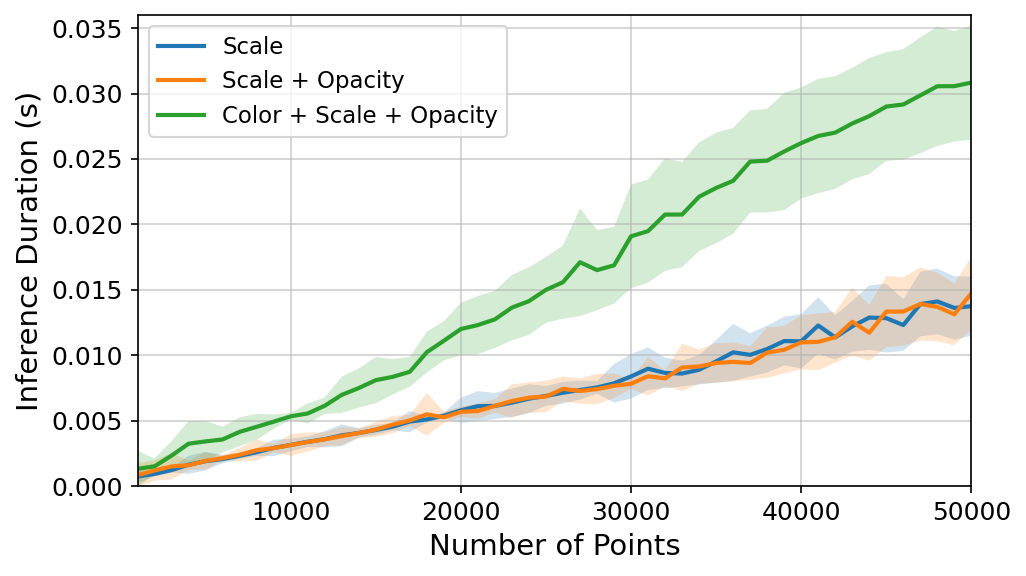

In [38]:
plt.rcParams["font.size"] = 12

# --- Plot results with error spans ---
labels = [
    "Scale",
    "Scale + Opacity",
    "Color + Scale + Opacity"
]

plt.figure(figsize=(7, 4), dpi=150)
for i, label in enumerate(labels):
    i = [1,2,0][i]
    mean = np.array(durations_mean[i])
    std  = np.array(durations_std[i])
    
    # Line plot for the mean
    plt.plot(num_pts, mean, linewidth=2, label=label)
    
    # Shaded region for ±1 std deviation
    plt.fill_between(num_pts, mean - std, mean + std, alpha=0.2)

plt.xlabel('Number of Points', fontsize=14)
plt.ylabel('Inference Duration (s)', fontsize=14)

plt.xlim(1000, 50000)
plt.ylim(0, 0.036)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()


Feature importance:
   feature  importance
3  opacity        3340
2  scale_z        3271
0  scale_x        3059
1  scale_y        2930


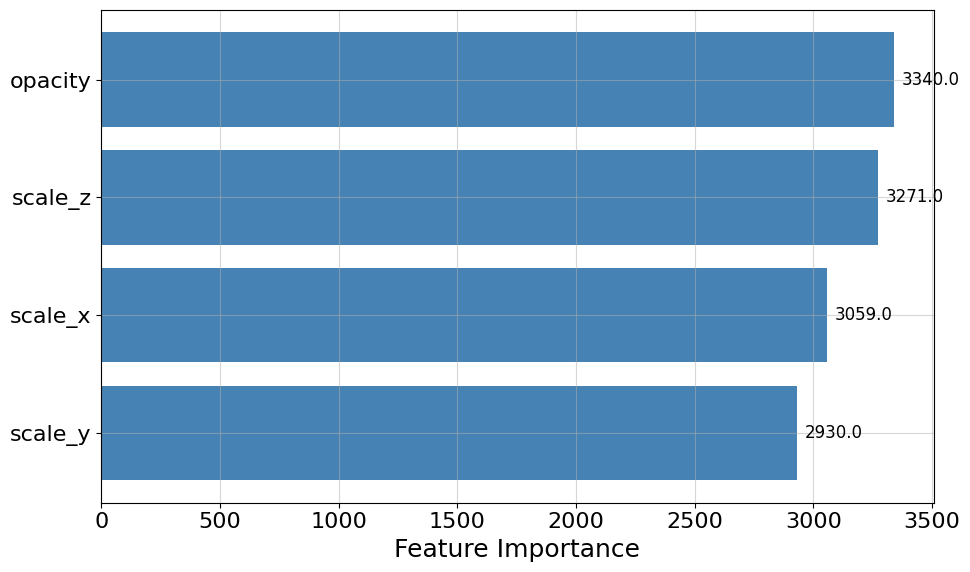

In [52]:
plt.rcParams['font.size'] = 16

# Get feature importance
try:
    importance = model.feature_importances_
    feature_names = model.feature_name_
except:
    importance = model.feature_importance(importance_type="split")
    feature_names = model.feature_name()

# Put into DataFrame
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values(by="importance", ascending=False)

print("Feature importance:")
print(feat_imp)

# Plot feature importance (split counts) with values on bars
plt.figure(figsize=(10,6))
bars = plt.barh(feat_imp["feature"], feat_imp["importance"], color="steelblue")
plt.gca().invert_yaxis()  # most important on top
plt.xlabel("Feature Importance", fontsize=18)

# Add text labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(feat_imp["importance"])*0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', va='center', fontsize=12)

plt.grid(True, alpha=.5)
plt.tight_layout()
plt.show()

# Optional: feature importance by gain
if hasattr(model, "feature_importance"):
    importance_gain = model.feature_importance(importance_type="gain")
    feat_imp_gain = pd.DataFrame({
        "feature": feature_names,
        "importance_gain": importance_gain
    }).sort_values(by="importance_gain", ascending=False)
    
    print("\nFeature importance by gain:")
    print(feat_imp_gain)
    
    # Plot gain importance with text
    plt.figure(figsize=(10,6))
    bars = plt.barh(feat_imp_gain["feature"], feat_imp_gain["importance_gain"], color="darkorange")
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (gain)", fontsize=16)
    plt.title("LightGBM Feature Importance by Gain", fontsize=18)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + max(feat_imp_gain["importance_gain"])*0.01, 
                 bar.get_y() + bar.get_height()/2,
                 f'{width:.1f}', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [59]:
test_df_lightgbm = test_df.copy()
test_df_lightgbm['is_fog'] = y_pred_lightgbm
test_df_lightgbm_fog   = test_df_lightgbm[test_df_lightgbm['is_fog'] == 1]
test_df_lightgbm_other = test_df_lightgbm[test_df_lightgbm['is_fog'] == 0]

pcm.convert_df_to_ply(test_df_lightgbm_fog, output_path="/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/fog_gaussian_lightgbm.ply")
pcm.convert_df_to_ply(test_df_lightgbm_other, output_path="/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/other_gaussian_lightgbm.ply")

test_df_lightgbm

Saved PLY format Splat to /home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/fog_gaussian_lightgbm.ply
Saved PLY format Splat to /home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/other_gaussian_lightgbm.ply


,pos_x,pos_y,pos_z,f_dc_0,f_dc_1,f_dc_2,f_rest_0,f_rest_1,f_rest_2,f_rest_3,...,scale_z,rot_0,rot_1,rot_2,rot_3,opacity,beta,alpha,is_fog,id
0,0.006477,0.920404,-0.447355,-0.370639,-0.412475,-0.441535,0.284927,0.216562,0.091778,-0.013241,...,-4.755654,0.683556,0.595376,-0.120228,0.136761,-0.295831,-1.0,-1.0,0.0,-1.0
1,0.260587,0.656357,-0.078467,0.834544,1.106422,1.016870,-0.232086,0.072377,0.062683,-0.023588,...,-4.033053,1.304243,0.246482,0.169167,-0.001631,-3.393897,-1.0,-1.0,0.0,-1.0
2,-0.214111,0.911233,-0.388400,-1.306608,-1.863695,-1.804585,0.221236,0.045090,0.175948,-0.163501,...,-4.964437,0.697073,-0.003514,0.099156,-0.552039,-1.081465,-1.0,-1.0,0.0,-1.0
3,-0.008309,0.791221,-0.312693,1.447613,1.222155,1.309501,-0.048766,-0.101439,0.078192,-0.066504,...,-14.115521,0.542486,-0.229233,-0.329898,0.447394,-3.033354,-1.0,-1.0,0.0,-1.0
4,-2.359237,0.906771,1.310131,0.693525,0.615265,0.519760,-0.007714,-0.068041,-0.097169,0.078921,...,-2.203195,0.962544,-0.072326,0.285937,-0.048231,-0.830322,-1.0,-1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82708,2.595374,-0.949818,0.133185,1.279532,1.278039,1.291736,0.019166,0.011086,-0.028843,0.002652,...,0.235023,1.673931,0.036263,-0.323722,0.204935,6.214955,-1.0,-1.0,0.0,-1.0
82709,2.166013,-0.470410,2.131600,1.212328,1.216261,1.222239,-0.019134,0.007248,-0.007227,0.018954,...,-1.364115,0.214004,-0.993105,-0.700994,-0.100832,-0.973270,-1.0,-1.0,0.0,-1.0
82710,-1.277386,-1.181440,-2.092138,1.197960,1.216639,1.235715,0.017220,-0.018290,-0.020424,-0.020423,...,-0.235699,0.284716,0.636281,0.341881,0.380356,17.336830,-1.0,-1.0,0.0,-1.0
82711,0.007975,-1.483418,-3.122571,1.244344,1.248401,1.190228,0.012784,-0.001513,-0.002390,0.004082,...,-1.112162,1.147557,-0.494321,0.025597,-0.017315,16.731098,-1.0,-1.0,0.0,-1.0


##### b. Deep Learning

**b-1. MLP**

In [8]:
model = joblib.load(f'{experiment_dir}/models/DL_MLP_model.pkl')
model = model.to(device)

X_test_tensor = torch.FloatTensor(np.array(X_test)).to(device)
y_pred_dl_prob = torch.sigmoid(model(X_test_tensor).cpu().detach()).numpy()
y_pred_dl = (y_pred_dl_prob > 0.5).astype(int).flatten()

y_pred_dl.sum()


np.int64(9257)

In [ ]:
test_df_dl = test_df.copy()
test_df_dl['is_fog'] = y_pred_dl

test_df_dl_fog   = test_df_dl[test_df_dl['is_fog'] == 1]
test_df_dl_other = test_df_dl[test_df_dl['is_fog'] == 0]

pcm.convert_df_to_ply(test_df_dl_fog, output_path="/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/fog_gaussian_dl.ply")
pcm.convert_df_to_ply(test_df_dl_other, output_path="/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/other_gaussian_dl.ply")

**b-2. Transformer**

In [12]:
# model = joblib.load(f'{experiment_dir}/models/DL_TRANSFORMER_model.pkl')
# model = model.to(device)

# X_test_tensor = torch.FloatTensor(np.array(X_test)).to(device)
# y_pred_dl_prob = torch.sigmoid(model(X_test_tensor).cpu().detach()).numpy()
# y_pred_dl = (y_pred_dl_prob > 0.5).astype(int).flatten()

# y_pred_dl.sum()

In [11]:
test_df_dl = test_df.copy()
test_df_dl['is_fog'] = y_pred_dl

test_df_dl_fog   = test_df_dl[test_df_dl['is_fog'] == 1]
test_df_dl_other = test_df_dl[test_df_dl['is_fog'] == 0]

pcm.convert_df_to_ply(test_df_dl_fog, output_path="/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/fog_gaussian_dl.ply")
pcm.convert_df_to_ply(test_df_dl_other, output_path="/home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/other_gaussian_dl.ply")

Saved PLY format Splat to /home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/fog_gaussian_dl.ply
Saved PLY format Splat to /home/tsy/Documents/TeamM_Defog/kpro-dehaze/data/output/temp/other_gaussian_dl.ply
